# Test tiger with location scale regression

In [80]:
import jax
import jax.numpy as jnp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set path such that interpreter finds tigerpy
import sys
sys.path.append("..")

import tigerpy.model as tiger
import tigerpy.bbvi as bbvi

# Use distributions and bijectors from tensorflow probability
import tensorflow_probability.substrates.jax.distributions as tfjd

rng = np.random.default_rng(42)

## Simulate data

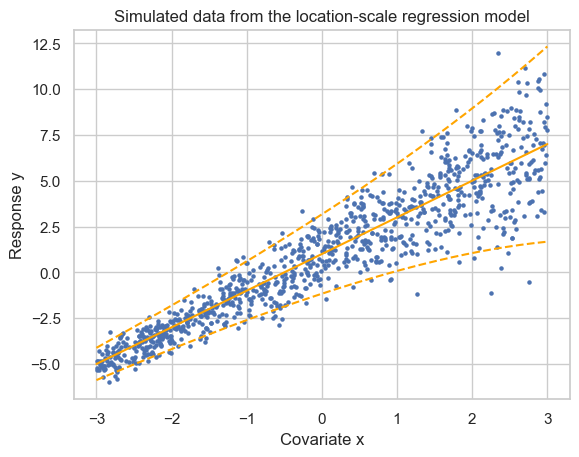

In [81]:
# Sample size and true parameters
n = 1000
true_beta = np.array([1.0, 2.0])
true_gamma = np.array([0.1, 0.3])

# Data-generating process
x0 = rng.uniform(size=n, low=-3, high=3)
X_mat = np.column_stack([np.ones(n), x0])
Z_mat = np.column_stack([np.ones(n), x0])
log_sigma = Z_mat @ true_gamma
sigma = np.exp(log_sigma)
eps = rng.normal(scale=sigma, size=n)
response_vec = X_mat @ true_beta + eps

# Data to plot the linear regression line
x_plot = np.linspace(-3, 3, num=200)
X_plot = np.column_stack([np.ones(200), x_plot])
Z_plot = np.column_stack([np.ones(200), x_plot])
mean_plot =  X_plot @ true_beta
sigma_plot = np.exp(Z_plot @ true_gamma)

# Set the seaborn theme
sns.set_theme(style="whitegrid")

# Plot the simulated data
plt.scatter(x0, response_vec, s = 5)
plt.plot(x_plot, mean_plot, color="orange")
plt.plot(x_plot, mean_plot - 1.96*sigma_plot, color="orange", linestyle="--")
plt.plot(x_plot, mean_plot + 1.96*sigma_plot, color="orange", linestyle="--")
plt.title("Simulated data from the location-scale regression model")
plt.xlabel("Covariate x")
plt.ylabel("Response y")
plt.show()

## Set up model in tigerpy

In [82]:
# Set up design matrix location
X = tiger.Obs(name = "X_loc")
X.fixed(data = x0)

# Set up design matrix scale
Z = tiger.Obs(name = "Z_scale")
Z.fixed(data = x0)

# Set up hyperparameters for the location
beta_loc = tiger.Hyper(0.0, name="beta_loc")
beta_scale = tiger.Hyper(100.0, name="beta_scale")

# Set up parameters for the location
beta_dist = tiger.Dist(tfjd.Normal, loc=beta_loc, scale=beta_scale)
beta = tiger.Param(value=np.array([0.0, 0.0]), distribution=beta_dist, name="beta")

# Set up hyperparameters for the scale
gamma_loc = tiger.Hyper(0.0, name="gamma_loc")
gamma_scale = tiger.Hyper(10.0, name="gamma_scale")

# Set up parameters for the scale
gamma_dist = tiger.Dist(tfjd.Normal, loc=gamma_loc, scale=gamma_scale)
gamma = tiger.Param(value=np.array([0.0, 0.0]), distribution=gamma_dist, name="gamma")

# Set up the linear predictors
lpred_loc = tiger.Lpred(obs=X, beta=beta)
lpred_scale = tiger.Lpred(obs=Z, function=jnp.exp, gamma=gamma)

# Set up response distribution
response_dist = tiger.Dist(tfjd.Normal, loc=lpred_loc, scale=lpred_scale)
m = tiger.Model(response=response_vec, distribution=response_dist)

In [83]:
jnp.sum(m.log_lik)

Array(-8436.268, dtype=float32)

In [84]:
m.log_prior

Array(-17.491264, dtype=float32)

In [85]:
m.log_prob

Array(-8453.759, dtype=float32)

In [86]:
graph = tiger.ModelGraph(model=m)
graph.build_graph()

In [87]:
graph.logprob()

Array(-8453.759, dtype=float32)

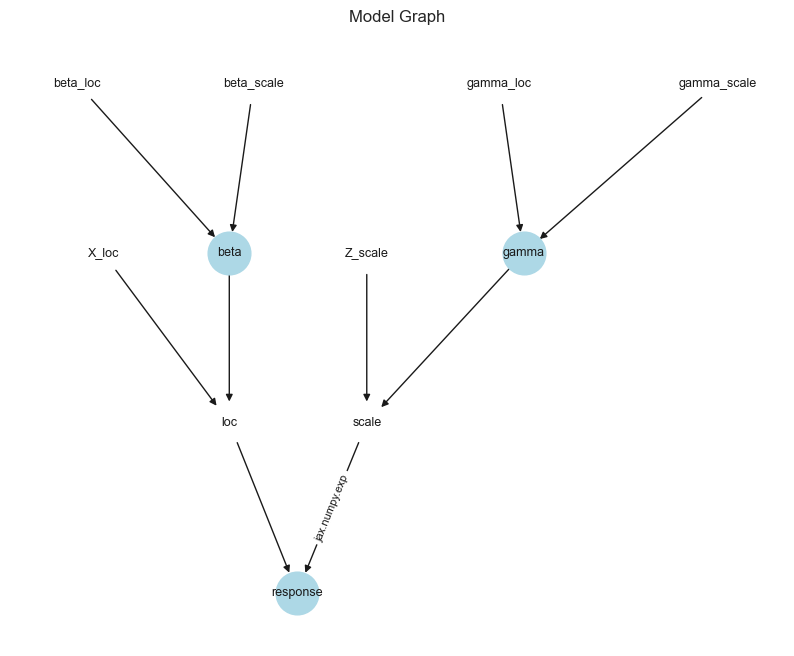

In [88]:
graph.visualize_graph()

## Test Location Scale regression improvements 

In [89]:
import tigerpy.distributions.mvn as mvn
from tigerpy.bbvi.transform import (
    log_cholesky_parametrization_to_tril,
    hessian
)
from tigerpy.bbvi.init_bbvi import (
    add_jitter
)

In [75]:
q = bbvi.Bbvi(graph=graph, 
              model_init=True, 
              loc_prec=1.0, 
              scale_prec=1.0)
key = jax.random.PRNGKey(27)

In [76]:
q.init_var_params

{'beta': {'loc': Array([0.9378593, 1.9952936], dtype=float32),
  'log_cholesky_prec': Array([0., 0., 0.], dtype=float32, weak_type=True)},
 'gamma': {'loc': Array([0.11262584, 0.2886592 ], dtype=float32),
  'log_cholesky_prec': Array([0., 0., 0.], dtype=float32, weak_type=True)}}

In [77]:
loc_beta, log_chol__prec_beta = q.init_var_params["beta"]["loc"], q.init_var_params["beta"]["log_cholesky_prec"]
loc_gamma, log_chol__prec_gamma = q.init_var_params["gamma"]["loc"], q.init_var_params["gamma"]["log_cholesky_prec"]
lower_tri_beta = log_cholesky_parametrization_to_tril(log_chol__prec_beta, d=loc_beta.shape[0])
lower_tri_gamma = log_cholesky_parametrization_to_tril(log_chol__prec_gamma, d=loc_gamma.shape[0])

In [78]:
noise_beta = mvn.mvn_sample_noise(key=key, shape=lower_tri_beta.shape, S=64)
noise_gamma = mvn.mvn_sample_noise(key=key, shape=lower_tri_gamma.shape, S=64)
samples_beta = mvn.mvn_precision_chol_sample(loc=loc_beta, precision_matrix_chol=lower_tri_beta, noise=noise_beta)
samples_gamma = mvn.mvn_precision_chol_sample(loc=loc_gamma, precision_matrix_chol=lower_tri_gamma, noise=noise_gamma)

In [79]:
test_samples = {"beta": samples_beta, "gamma": samples_gamma}
test_noise = {"beta": noise_beta, "gamma": noise_gamma}
batch_idx = jax.random.choice(key, n, (256,), replace=False)
data_new = jax.tree_map(lambda x: x[batch_idx], q.data)

In [66]:
test_model_loc = {kw: value["loc"] for kw, value in q.init_var_params.items()}
test_model_log_chol_prec = {kw: value["log_cholesky_prec"] for kw, value in q.init_var_params.items()}

In [71]:
noise_samples = {"beta": samples_beta[0,:], "gamma": samples_gamma[0,:]}

In [ ]:
def calc_control_variate(var_params, batch_data, noise_sample, num_obs):
    loc_params = {kw: value["loc"] for kw, value in var_params.items()}
    log_chol_prec_params = {kw: value["log_cholesky_prec"] for kw, value in var_params.items()}
    first = jax.grad(q.mc_logprob, argnums=1)(batch_data,
                                              loc_params,
                                              num_obs)
    second =  hessian(q.mc_logprob, argnums=1)(batch_data,
                                               loc_params,
                                               num_obs)
    diff = 







In [17]:
# first order approx 
grad_model = jax.grad(q.mc_logprob, argnums=1)
grad_model(data_new, test_model_loc, q.num_obs)

{'beta': Array([-48.15022, 239.26175], dtype=float32),
 'gamma': Array([-36.812416, -14.612378], dtype=float32)}

In [67]:
def hessian(f, argnums):
  return jax.jacfwd(jax.grad(f, argnums=argnums), argnums=argnums)

In [68]:
hessian_model = hessian(q.mc_logprob, argnums=1)

In [69]:
hessian_model(data_new, test_model_loc, q.num_obs)

{'beta': {'beta': Array([[-1277.509 ,  1934.0669],
         [ 1934.0669, -5364.5547]], dtype=float32),
  'gamma': Array([[  96.300415, -478.52353 ],
         [-478.5236  , 1184.2206  ]], dtype=float32)},
 'gamma': {'beta': Array([[  96.30039, -478.52356],
         [-478.5235 , 1184.2205 ]], dtype=float32),
  'gamma': Array([[-1926.381   ,    29.026306],
         [   29.026398, -5592.8     ]], dtype=float32)}}

In [44]:
test_model_log_chol_prec = {kw: value["log_cholesky_prec"] for kw, value in q.init_var_params.items()}

In [50]:
test_noise["beta"].shape

(64, 2)

In [48]:
mvn.mvn_precision_chol_sample(test_model_loc["beta"], test_model_log_chol_prec["beta"], test_noise["beta"])

TypeError: triangular_solve requires a.ndim to be at least 2, got 1.

In [24]:
q.mc_logprob(data_new, test_samples, q.num_obs)

Array(-3.238086e+08, dtype=float32)

In [ ]:
test = jax.jacfwd(mvn.mvn_precision_chol_sample, argnums=(0,1))
test(loc_beta, lower_tri_beta, noise=noise_beta)

In [32]:
test1, grad = jax.value_and_grad(q.lower_bound, has_aux=True)(q.init_var_params, 
                                                              data_new,
                                                              num_obs=q.num_obs,
                                                              num_var_samples=64,
                                                              key=key)

In [33]:
q.lower_bound(q.init_var_params, 
              data_new,
              num_obs=q.num_obs,
              num_var_samples=64,
              key=key)

(Array(8.5275786e+09, dtype=float32),
 {'beta': Array([[ 1.2278506 ,  0.6251546 ],
         [-0.81819105, -0.9523672 ],
         [ 0.6367647 ,  1.6163673 ],
         [ 1.2212228 ,  0.13758588],
         [ 0.66972876,  0.7680518 ],
         [-0.78234386,  0.43892196],
         [ 1.0059518 ,  1.6984864 ],
         [ 0.7039658 , -0.08554774],
         [ 0.7102521 , -1.7188014 ],
         [-1.0145243 ,  1.3021189 ],
         [ 1.2540096 ,  2.5784535 ],
         [ 0.28852972,  1.7837807 ],
         [-0.30060053, -0.36912638],
         [-0.9613142 , -0.08366327],
         [-0.5447775 ,  1.9736478 ],
         [-1.4183557 ,  0.12044229],
         [-0.71877915,  0.39001206],
         [-0.6257973 , -1.2532703 ],
         [-0.42462257,  0.17059839],
         [-0.6610704 ,  0.10967038],
         [ 1.1868529 , -0.5415852 ],
         [ 1.6219513 , -1.0992616 ],
         [ 1.708146  , -1.063075  ],
         [-0.9873985 , -0.7176445 ],
         [-0.7419304 ,  1.0984219 ],
         [ 1.4065734 ,  0.890

## Inference with BBVI

In [32]:
q = bbvi.Bbvi(graph=graph,
              model_init=True,
              loc_prec=10.0,
              scale_prec=10.0)

In [33]:
q.init_var_params

{'beta': {'loc': Array([0.9378593, 1.9952936], dtype=float32),
  'log_cholesky_prec': Array([2.3025851, 0.       , 2.3025851], dtype=float32, weak_type=True)},
 'gamma': {'loc': Array([0.11262584, 0.2886592 ], dtype=float32),
  'log_cholesky_prec': Array([2.3025851, 0.       , 2.3025851], dtype=float32, weak_type=True)}}

In [34]:
q.run_bbvi(step_size=0.01,
           threshold=1e-2,
           key_int=27,
           batch_size=1000,
           num_var_samples=64,
           chunk_size=50,
           epochs=500)

Start optimization ...
Finished optimization.


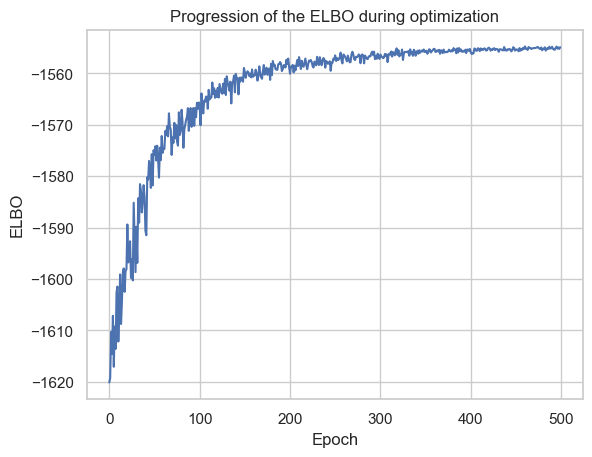

In [35]:
q.plot_elbo()

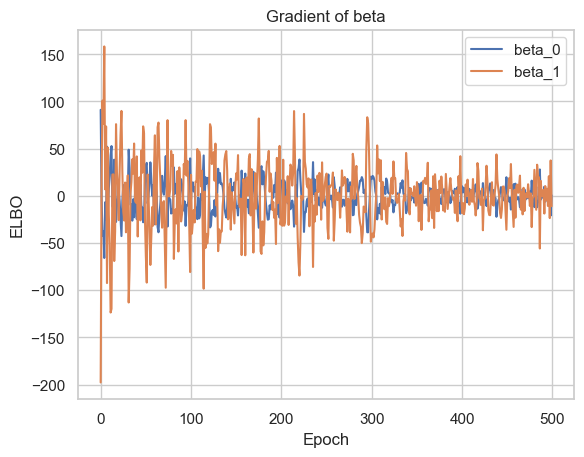

In [36]:
plot_grad_beta = np.vstack([d["beta"]["loc"] for d in q.elbo_hist["grad"]])
plt.plot(q.elbo_hist["epoch"], plot_grad_beta[:,0], label="beta_0")
plt.plot(q.elbo_hist["epoch"], plot_grad_beta[:,1], label="beta_1")
plt.title("Gradient of beta")
plt.xlabel("Epoch")
plt.ylabel("ELBO")
plt.legend()
plt.show()

In [37]:
np.std(plot_grad_beta, axis=0)

array([15.397092, 34.87515 ], dtype=float32)

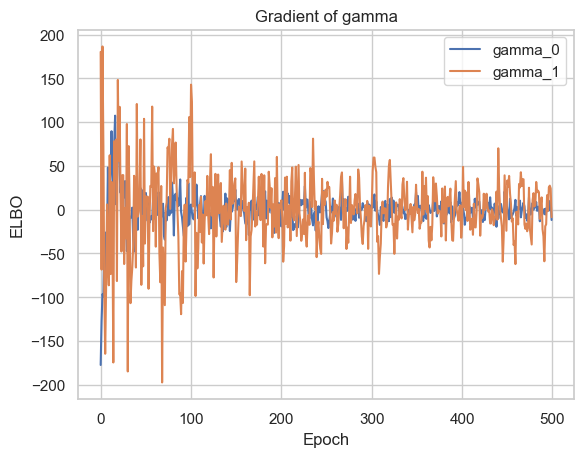

In [38]:
plot_grad_gamma = np.vstack([d["gamma"]["loc"] for d in q.elbo_hist["grad"]])
plt.plot(q.elbo_hist["epoch"], plot_grad_gamma[:,0], label="gamma_0")
plt.plot(q.elbo_hist["epoch"], plot_grad_gamma[:,1], label="gamma_1")
plt.title("Gradient of gamma")
plt.xlabel("Epoch")
plt.ylabel("ELBO")
plt.legend()
plt.show()

In [39]:
np.std(plot_grad_gamma, axis=0)

array([19.802717, 43.28595 ], dtype=float32)

In [41]:
q.return_loc_params

{'beta': {'loc': Array([0.9400299, 2.0169568], dtype=float32)},
 'gamma': {'loc': Array([0.11413014, 0.27995238], dtype=float32)}}

In [42]:
q.trans_var_params

{'beta': {'loc': Array([0.9400299, 2.0169568], dtype=float32),
  'cov': Array([[8.8520150e-04, 1.5246042e-05],
         [1.5246041e-05, 4.4515467e-04]], dtype=float32)},
 'gamma': {'loc': Array([0.11413014, 0.27995238], dtype=float32),
  'cov': Array([[6.4132758e-04, 8.4774035e-07],
         [8.4774041e-07, 4.6251656e-04]], dtype=float32)}}